<a href="https://colab.research.google.com/github/duybluemind1988/Data-science/blob/master/Statistic/Python_statistics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://reneshbedre.github.io/blog/anova.html

# One-way (one factor) ANOVA with Python

ANOVA Hypotheses

- Null hypotheses: Groups means are equal (no variation in means of groups)
- Alternative hypotheses: At least, one group mean is different from other groups

ANOVA Assumptions

- Residuals (experimental error) are normally distributed (Shapiro-Wilks Test)
- Homogeneity of variances (variances are equal between treatment groups) (Levene or Bartlett Test)
- Observations are sampled independently from each other

How ANOVA works?

- Check sample sizes: equal number of observation in each group
- Calculate Mean Square for each group (MS) (SS of group/level-1); level-1 is a degree of freedom (df) for a group
- Calculate Mean Square error (MSE) (SS error/df of residuals)
- Calculate F-value (MS of group/MSE)

In [ ]:
# I am using Python 3
# load packages
import pandas as pd
# load data file
d = pd.read_csv("https://reneshbedre.github.io/assets/posts/anova/onewayanova.txt", sep="\t")
d

,A,B,C,D
0,25,45,30,54
1,30,55,29,60
2,28,29,33,51
3,36,56,37,62
4,29,40,27,73


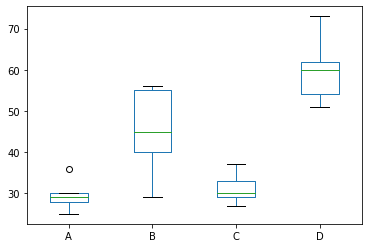

In [ ]:
# generate a boxplot to see the data distribution by treatments. Using boxplot, we can easily detect the differences 
# between different treatments
d.boxplot(column=['A', 'B', 'C', 'D'], grid=False)

In [ ]:
# load packages
import scipy.stats as stats
# stats f_oneway functions takes the groups as input and returns F and P-value
fvalue, pvalue = stats.f_oneway(d['A'], d['B'], d['C'], d['D'])
print(fvalue, pvalue)

17.492810457516338 2.639241146210922e-05


In [ ]:
# get ANOVA table as R like output
import statsmodels.api as sm
from statsmodels.formula.api import ols
# reshape the d dataframe suitable for statsmodels package 
d_melt = pd.melt(d.reset_index(), id_vars=['index'], value_vars=['A', 'B', 'C', 'D'])
# replace column names
d_melt.columns = ['index', 'treatments', 'value']
d_melt

,index,treatments,value
0,0,A,25
1,1,A,30
2,2,A,28
3,3,A,36
4,4,A,29
5,0,B,45
6,1,B,55
7,2,B,29
8,3,B,56
9,4,B,40


In [ ]:
# Ordinary Least Squares (OLS) model
model = ols('value ~ C(treatments)', data=d_melt).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(treatments),3010.95,3.0,17.49281,0.000026
Residual,918.00,16.0,NaN,NaN


In [ ]:
# note: if the data is balanced (equal sample size for each group), Type 1, 2, and 3 sums of squares
# (typ parameter) will produce similar results.

Interpretation: The P-value obtained from ANOVA analysis is significant (P<0.05), and therefore, we conclude that there are significant differences among treatments.

From ANOVA analysis, we know that treatment differences are statistically significant, but ANOVA does not tell which treatments are significantly different from each other. To know the pairs of significant different treatments, we will perform multiple pairwise comparison (Post-hoc comparison) analysis using Tukey HSD test.

## Test ANOVA assumptions

ANOVA Assumptions

- Residuals (experimental error) are normally distributed (Shapiro-Wilks Test)
- Homogeneity of variances (variances are equal between treatment groups) (Levene or Bartlett Test)
- Observations are sampled independently from each other

The Shapiro-Wilk test can be used to check the normal distribution of residuals . Null hypothesis: data is drawn from normal distribution.

In [ ]:
model.resid

0    -4.600000e+00
1     4.000000e-01
2    -1.600000e+00
3     6.400000e+00
4    -6.000000e-01
5     0.000000e+00
6     1.000000e+01
7    -1.600000e+01
8     1.100000e+01
9    -5.000000e+00
10   -1.200000e+00
11   -2.200000e+00
12    1.800000e+00
13    5.800000e+00
14   -4.200000e+00
15   -6.000000e+00
16    7.105427e-15
17   -9.000000e+00
18    2.000000e+00
19    1.300000e+01
dtype: float64

In [ ]:
# load packages
import scipy.stats as stats
w, pvalue = stats.shapiro(model.resid)
print(w, pvalue)

0.9685019850730896 0.7229772806167603


As the P-value is non significant, we fail to reject null hypothesis and conclude that data is drawn from normal distribution.

As the data is drawn from normal distribution, use Bartlett’s test to check the Homogeneity of variances. Null hypothesis: samples from populations have equal variances.

In [ ]:
# load packages
import scipy.stats as stats
w, pvalue = stats.bartlett(d['A'], d['B'], d['C'], d['D'])
print(w, pvalue)

5.687843565012841 0.1278253399753447


As the P-value (0.12) is non significant, we fail to reject null hypothesis and conclude that treatments have equal variances.

Levene test can be used to check the Homogeneity of variances when the data is not drawn from normal distribution.

In [ ]:
from scipy.stats import levene
stat, pvalue = levene(d['A'], d['B'], d['C'], d['D'])
print(stat, pvalue)

1.9219593192195938 0.16673281219949276


## Tukey HSD test

In [ ]:
#!pip install pingouin

In [ ]:
# load packages
from pingouin import pairwise_tukey
# perform multiple pairwise comparison (Tukey HSD)
# for unbalanced (unequal sample size) data, pairwise_tukey uses Tukey-Kramer test
m_comp = pairwise_tukey(data=d_melt, dv='value', between='treatments').round(3)
m_comp

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,A,B,29.6,45.0,-15.4,4.790616,-3.214618,0.010718,-1.836351
1,A,C,29.6,31.2,-1.6,4.790616,-0.333986,0.900000,-0.190790
2,A,D,29.6,60.0,-30.4,4.790616,-6.345739,0.001000,-3.625005
3,B,C,45.0,31.2,13.8,4.790616,2.880632,0.027410,1.645561
4,B,D,45.0,60.0,-15.0,4.790616,-3.131121,0.013679,-1.788654
5,C,D,31.2,60.0,-28.8,4.790616,-6.011753,0.001000,-3.434215


In [ ]:
m_comp['Result']=m_comp['p-tukey'].apply(lambda x: 'Different'if x<0.05 else 'Not different')

In [ ]:
m_comp

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges,Result
0,A,B,29.6,45.0,-15.4,4.790616,-3.214618,0.010718,-1.836351,Different
1,A,C,29.6,31.2,-1.6,4.790616,-0.333986,0.900000,-0.190790,Not different
2,A,D,29.6,60.0,-30.4,4.790616,-6.345739,0.001000,-3.625005,Different
3,B,C,45.0,31.2,13.8,4.790616,2.880632,0.027410,1.645561,Different
4,B,D,45.0,60.0,-15.0,4.790616,-3.131121,0.013679,-1.788654,Different
5,C,D,31.2,60.0,-28.8,4.790616,-6.011753,0.001000,-3.434215,Different


Above results from Tukey HSD suggests that except A-C, all other pairwise comparisons for treatments rejects null hypothesis (P-tukey<0.05) and indicates statistical significant differences.

# Two-way (two factor) ANOVA with Python

From dataset, there are two factors (independent variables) viz. genotypes and yield in years. Genotypes and years has five and three levels respectively (see one-way ANOVA to know factors and levels).

For this experimental design, there are two factors to evaluate, and therefore, two-way ANOVA method is suitable for analysis. Here, using two-way ANOVA, we can simultaneously evaluate how type of genotype and years affects the yields of plants. If you apply one-way ANOVA here, you can able to evaluate only one factor at a time.

From two-way ANOVA, we can tests three hypotheses 1) effect of genotype on yield 2) effect of time (years) on yield, and 3) effect of genotype and time (years) interactions on yield

In [ ]:
# load packages
import pandas as pd
import seaborn as sns
# load data file
d = pd.read_csv("https://reneshbedre.github.io/assets/posts/anova/twowayanova.txt", sep="\t")
d

,Genotype,1_year,2_year,3_year
0,A,1.53,4.08,6.69
1,A,1.83,3.84,5.97
2,A,1.38,3.96,6.33
3,B,3.60,5.70,8.55
4,B,2.94,5.07,7.95
5,B,4.02,7.20,8.94
6,C,3.99,6.09,10.02
7,C,3.30,5.88,9.63
8,C,4.41,6.51,10.38
9,D,3.75,5.19,11.40


In [ ]:
# reshape the d dataframe suitable for statsmodels package 
# you do not need to reshape if your data is already in stacked format. Compare d and d_melt tables for detail 
# understanding 
d_melt = pd.melt(d, id_vars=['Genotype'], value_vars=['1_year', '2_year', '3_year'])
# replace column names
d_melt.columns = ['Genotype', 'years', 'value']
d_melt.head(10)

,Genotype,years,value
0,A,1_year,1.53
1,A,1_year,1.83
2,A,1_year,1.38
3,B,1_year,3.60
4,B,1_year,2.94
5,B,1_year,4.02
6,C,1_year,3.99
7,C,1_year,3.30
8,C,1_year,4.41
9,D,1_year,3.75


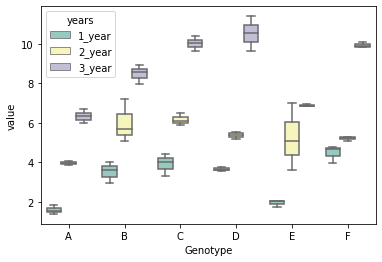

In [ ]:
# generate a boxplot to see the data distribution by genotypes and years. Using boxplot, we can easily detect the 
# differences between different groups
sns.boxplot(x="Genotype", y="value", hue="years", data=d_melt, palette="Set3") 

In [ ]:
# load packages
import statsmodels.api as sm
from statsmodels.formula.api import ols
# Ordinary Least Squares (OLS) model
# C(Genotype):C(years) represent interaction term
model = ols('value ~ C(Genotype) + C(years) + C(Genotype):C(years)', data=d_melt).fit()
anova_table = sm.stats.anova_lm(model, typ=2) #typ = 3 for unblanced
anova_table

,sum_sq,df,F,PR(>F)
C(Genotype),58.551733,5.0,32.748581,1.931655e-12
C(years),278.925633,2.0,390.014868,4.006243e-25
C(Genotype):C(years),17.122967,10.0,4.788525,2.230094e-04
Residual,12.873000,36.0,NaN,NaN


Interpretation: The P-value obtained from ANOVA analysis for genotype, years, and interaction are statistically significant (P<0.05). We conclude that type of genotype significantly affects the yield outcome, time (years) significantly affects the yield outcome, and interaction of both genotype and time (years) significantly affects the yield outcome.

Note: If you have unbalanced (unequal sample size for each group) data, you can perform similar steps as described for two-way ANOVA with the balanced design but set `typ=3`. Type 3 sums of squares (SS) is recommended for an unbalanced design for multifactorial ANOVA.

## Test ANOVA assumptions

Similar to one-way ANOVA, you can use Levene and Shapiro-Wilk test to validate the assumptions for homogeneity of variances and normal distribution of residuals.

In [ ]:
# load packages
import scipy.stats as stats
w, pvalue = stats.shapiro(model.resid)
print(w, pvalue)

0.8978845477104187 0.00023986827000044286


As the P-value is  significant, we reject null hypothesis and conclude that data is drawn from non normal distribution.

Levene test can be used to check the Homogeneity of variances when the data is not drawn from normal distribution.

In [ ]:
from scipy.stats import levene
stat, pvalue = levene(d['1_year'], d['2_year'], d['3_year'])
print(stat, pvalue)

3.7640414132406605 0.02987100822975102


As the P-value is significant, we reject null hypothesis and conclude that treatments have non equal variances.

## Tukey HSD test.

Now, we know that genotype and time (years) differences are statistically significant, but ANOVA does not tell which genotype and time (years) are significantly different from each other. To know the pairs of significant different genotype and time (years), perform multiple pairwise comparison (Post-hoc comparison) analysis using Tukey HSD test.



In [ ]:
d_melt.head()

,Genotype,years,value
0,A,1_year,1.53
1,A,1_year,1.83
2,A,1_year,1.38
3,B,1_year,3.60
4,B,1_year,2.94


In [ ]:
# load packages
from pingouin import pairwise_tukey
# perform multiple pairwise comparison (Tukey HSD)
# for unbalanced (unequal sample size) data, pairwise_tukey uses Tukey-Kramer test
m_comp = pairwise_tukey(data=d_melt, dv='value', between='Genotype').round(3)
m_comp['Result']=m_comp['p-tukey'].apply(lambda x: 'Different'if x<0.05 else 'Not different')
m_comp

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges,Result
0,A,B,3.957,5.997,-2.040,1.196,-1.706,0.523,-0.766,Not different
1,A,C,3.957,6.690,-2.733,1.196,-2.286,0.207,-1.026,Not different
2,A,D,3.957,6.517,-2.560,1.196,-2.141,0.273,-0.961,Not different
3,A,E,3.957,4.677,-0.720,1.196,-0.602,0.900,-0.270,Not different
4,A,F,3.957,6.530,-2.573,1.196,-2.152,0.267,-0.966,Not different
5,B,C,5.997,6.690,-0.693,1.196,-0.580,0.900,-0.260,Not different
6,B,D,5.997,6.517,-0.520,1.196,-0.435,0.900,-0.195,Not different
7,B,E,5.997,4.677,1.320,1.196,1.104,0.864,0.496,Not different
8,B,F,5.997,6.530,-0.533,1.196,-0.446,0.900,-0.200,Not different
9,C,D,6.690,6.517,0.173,1.196,0.145,0.900,0.065,Not different


In [ ]:
m_comp = pairwise_tukey(data=d_melt, dv='value', between='years').round(3)
m_comp['Result']=m_comp['p-tukey'].apply(lambda x: 'Different'if x<0.05 else 'Not different')
m_comp

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges,Result
0,1_year,2_year,3.172,5.318,-2.147,0.439,-4.887,0.001,-1.593,Different
1,1_year,3_year,3.172,8.693,-5.522,0.439,-12.572,0.001,-4.097,Different
2,2_year,3_year,5.318,8.693,-3.375,0.439,-7.684,0.001,-2.504,Different


# pingouin Statistic

https://pingouin-stats.org/index.html

In [ ]:
import numpy as np
import pingouin as pg

np.random.seed(123)
mean, cov, n = [4, 5], [(1, .6), (.6, 1)], 30
x, y = np.random.multivariate_normal(mean, cov, n).T

In [ ]:
x

array([4.52499109, 4.42053181, 3.77897093, 6.36230346, 3.25533028,
       4.64956937, 2.95178623, 4.59135733, 1.04899568, 2.92923908,
       2.67380187, 4.31118852, 5.40671611, 3.82758588, 4.51066978,
       5.48020001, 5.89750199, 3.24810462, 3.68967198, 4.65983923,
       5.492979  , 4.09301762, 3.7024475 , 1.67554352, 2.12366377,
       5.62202531, 2.79728088, 3.49523787, 2.41851903, 2.18400827])

In [ ]:
y

array([6.41704397, 4.07326086, 6.25606067, 6.97867234, 3.4800941 ,
       5.5648591 , 3.38033491, 5.20286174, 4.00491662, 4.2746547 ,
       5.00715313, 6.36288199, 5.83629382, 3.54973502, 4.73989277,
       3.97706582, 6.27151276, 4.09280014, 5.30523709, 5.91352322,
       4.94770443, 5.60624519, 4.69186599, 3.04486339, 5.12552003,
       5.69290489, 3.08347187, 5.45166315, 4.98813694, 4.14050216])

In [ ]:
# T-test
pg.ttest(x, y)

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,-3.400706,58,two-sided,0.001222,"[-1.68, -0.43]",0.878059,26.155,0.916807


In [ ]:
#2. Pearson’s correlation
pg.corr(x, y)

,n,r,CI95%,r2,adj_r2,p-val,BF10,power
pearson,30,0.594785,"[0.3, 0.79]",0.353769,0.3059,0.000527,69.723,0.950373


In [ ]:
# Introduce an outlier
x[5] = 18
# Use the robust Shepherd's pi correlation
pg.corr(x, y, method="shepherd")

,n,outliers,r,CI95%,r2,adj_r2,p-val,power
shepherd,30,1,0.561084,"[0.25, 0.77]",0.314815,0.264061,0.001543,0.916576


In [ ]:
# 4. Test the normality of the data
display(pg.normality(x))                                    # Univariate normality
pg.multivariate_normality(np.column_stack((x, y))) 

,W,pval,normal
0,0.615321,1.128503e-07,False


HZResults(hz=1.6967733646126617, pval=0.00018201726664169923, normal=False)

## 5. One-way ANOVA using a pandas DataFrame

In [ ]:
# Read an example dataset
df = pg.read_dataset('mixed_anova')
df

,Scores,Time,Group,Subject
0,5.971435,August,Control,0
1,4.309024,August,Control,1
2,6.932707,August,Control,2
3,5.187348,August,Control,3
4,4.779411,August,Control,4
...,...,...,...,...
175,6.176981,June,Meditation,55
176,8.523692,June,Meditation,56
177,6.522273,June,Meditation,57
178,4.990568,June,Meditation,58


In [ ]:
# Run the ANOVA
aov = pg.anova(data=df, dv='Scores', between='Group', detailed=True)
aov

,Source,SS,DF,MS,F,p-unc,np2
0,Group,5.459963,1,5.459963,5.243656,0.0232,0.028616
1,Within,185.342729,178,1.041251,NaN,NaN,NaN


## 6. Repeated measures ANOVA

In [ ]:
pg.rm_anova(data=df, dv='Scores', within='Time', subject='Subject', detailed=True)

,Source,SS,DF,MS,F,p-unc,np2,eps
0,Time,7.628428,2,3.814214,3.912796,0.022629,0.062194,0.998751
1,Error,115.027023,118,0.974805,NaN,NaN,NaN,NaN


he detailed ANOVA summary table includes the following columns:

- SS : sums of squares
- DF : degrees of freedom
- MS : mean squares (= SS / DF)
- F : F-value (test statistic)
- p-unc : uncorrected p-values
- np2 : partial eta-square effect size *

In one-way ANOVA, partial eta-square is the same as eta-square and generalized eta-square.

In the example above, there is a main effect of group (F(3, 15) = 6.79, p = .004)), so we can reject the null hypothesis that the groups have equal means.

## 8. Post-hoc tests corrected for multiple-comparisons

In [ ]:
df.head()

,Scores,Time,Group,Subject
0,5.971435,August,Control,0
1,4.309024,August,Control,1
2,6.932707,August,Control,2
3,5.187348,August,Control,3
4,4.779411,August,Control,4


In [ ]:
# FDR-corrected post hocs with Hedges'g effect size
posthoc = pg.pairwise_ttests(data=df, dv='Scores', within='Time', subject='Subject',
                             parametric=True, padjust='fdr_bh', effsize='hedges')

# Pretty printing of table
pg.print_table(posthoc, floatfmt='.3f')


POST HOC TESTS

Contrast    A        B        Paired    Parametric         T     dof  Tail         p-unc    p-corr  p-adjust      BF10    hedges
----------  -------  -------  --------  ------------  ------  ------  ---------  -------  --------  ----------  ------  --------
Time        August   January  True      True          -1.740  59.000  two-sided    0.087     0.131  fdr_bh       0.582    -0.328
Time        August   June     True      True          -2.743  59.000  two-sided    0.008     0.024  fdr_bh       4.232    -0.483
Time        January  June     True      True          -1.024  59.000  two-sided    0.310     0.310  fdr_bh       0.232    -0.170



## 9. Two-way mixed ANOVA

In [ ]:
# Compute the two-way mixed ANOVA and export to a .csv file
aov = pg.mixed_anova(data=df, dv='Scores', between='Group', within='Time',
                     subject='Subject', correction=False, effsize="np2")
pg.print_table(aov)


ANOVA SUMMARY

Source          SS    DF1    DF2     MS      F    p-unc    np2      eps
-----------  -----  -----  -----  -----  -----  -------  -----  -------
Group        5.460      1     58  5.460  5.052    0.028  0.080  nan
Time         7.628      2    116  3.814  4.027    0.020  0.065    0.999
Interaction  5.167      2    116  2.584  2.728    0.070  0.045  nan



# Apply ANOVA to Sonion data (Gage RnR)

## Import data

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [53]:
path='https://github.com/duybluemind1988/Data-science/blob/master/Data/Raw%20data%20for%20python%20RnR.xlsx?raw=true'
df=pd.read_excel(path)
df

,Norm file,ID,Sensitivity,Time,Unnamed: 4,Unnamed: 5,Unnamed: 6,THD 1,Unnamed: 8,Unnamed: 9,THD 2,Unnamed: 11,Unnamed: 12,THD3,Unnamed: 14,Unnamed: 15,THD4,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Rubbing,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Phase,SSPL 1,SSPL 2,...,SPL 13,Unnamed: 94,FREQ 14,SPL 14,Unnamed: 97,FREQ 15,SPL 15,Unnamed: 100,FREQ 16,SPL 16,Unnamed: 103,FREQ 17,SPL 17,Unnamed: 106,FREQ 18,SPL 18,FREQ 19,SPL 19,FREQ 20,Unnamed: 112,Unnamed: 113,Unnamed: 114,Unnamed: 115,Unnamed: 116,Unnamed: 117,Unnamed: 118,Unnamed: 119,Unnamed: 120,Unnamed: 121,Unnamed: 122,Unnamed: 123,Unnamed: 124,Unnamed: 125,Unnamed: 126,Unnamed: 127,Unnamed: 128,Unnamed: 129,Unnamed: 130,Unnamed: 131,Unnamed: 132
0,2323,10,0.0128,2019-03-05 13:23:41,1,0,850,2.77,0,1300,2.07,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,63.33,0,0,0,0,0,0,0,-8.82,0,0,...,0,-1,0,0,-1,0,0,-1,0,0,-1,0,0,-1,0,0,-1,0,0,-1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2323,10,0.0128,2019-03-05 13:23:53,1,0,850,2.83,0,1300,1.94,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,61.71,0,0,0,0,0,0,0,-7.53,0,0,...,0,-1,0,0,-1,0,0,-1,0,0,-1,0,0,-1,0,0,-1,0,0,-1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2323,10,0.0128,2019-03-05 13:24:14,1,0,850,3.08,0,1300,2.85,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,58.04,0,0,0,0,0,0,0,-10.39,0,0,...,0,-1,0,0,-1,0,0,-1,0,0,-1,0,0,-1,0,0,-1,0,0,-1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2323,10,0.0128,2019-03-05 13:24:29,1,0,850,2.69,0,1300,2.21,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,61.70,0,0,0,0,0,0,0,-9.52,0,0,...,0,-1,0,0,-1,0,0,-1,0,0,-1,0,0,-1,0,0,-1,0,0,-1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2323,10,0.0128,2019-03-05 13:24:40,1,0,850,2.28,0,1300,2.02,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,54.15,0,0,0,0,0,0,0,-8.66,0,0,...,0,-1,0,0,-1,0,0,-1,0,0,-1,0,0,-1,0,0,-1,0,0,-1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,2323,10,0.0128,2019-03-05 13:46:55,1,0,850,3.02,0,1300,3.05,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,59.71,0,0,0,0,0,0,0,-9.45,0,0,...,0,-1,0,0,-1,0,0,-1,0,0,-1,0,0,-1,0,0,-1,0,0,-1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
86,2323,10,0.0128,2019-03-05 13:47:10,1,0,850,3.14,0,1300,2.58,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,59.57,0,0,0,0,0,0,0,-7.78,0,0,...,0,-1,0,0,-1,0,0,-1,0,0,-1,0,0,-1,0,0,-1,0,0,-1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
87,2323,10,0.0128,2019-03-05 13:47:24,1,0,850,2.84,0,1300,3.06,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,63.93,0,0,0,0,0,0,0,-11.19,0,0,...,0,-1,0,0,-1,0,0,-1,0,0,-1,0,0,-1,0,0,-1,0,0,-1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
88,2323,10,0.0128,2019-03-05 13:47:36,1,0,850,3.11,0,1300,2.75,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,61.58,0,0,0,0,0,0,0,-8.18,0,0,...,0,-1,0,0,-1,0,0,-1,0,0,-1,0,0,-1,0,0,-1,0,0,-1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [54]:
x=np.array([1,2,3])
appraiser=np.repeat(x,30)
df['Appraiser']=appraiser
x=np.array(range(1,11))
sample=np.tile(x,9)
df['Sample']=sample

In [55]:
cols = df.columns.tolist()
cols = cols[-2:] + cols[:-2]
df = df[cols]
df.columns = df.columns.str.replace(' ', '')
df.head()

,Appraiser,Sample,Normfile,ID,Sensitivity,Time,Unnamed:4,Unnamed:5,Unnamed:6,THD1,Unnamed:8,Unnamed:9,THD2,Unnamed:11,Unnamed:12,THD3,Unnamed:14,Unnamed:15,THD4,Unnamed:17,Unnamed:18,Unnamed:19,Unnamed:20,Unnamed:21,Unnamed:22,Unnamed:23,Unnamed:24,Unnamed:25,Unnamed:26,Unnamed:27,Unnamed:28,Rubbing,Unnamed:30,Unnamed:31,Unnamed:32,Unnamed:33,Unnamed:34,Unnamed:35,Unnamed:36,Phase,...,SPL13,Unnamed:94,FREQ14,SPL14,Unnamed:97,FREQ15,SPL15,Unnamed:100,FREQ16,SPL16,Unnamed:103,FREQ17,SPL17,Unnamed:106,FREQ18,SPL18,FREQ19,SPL19,FREQ20,Unnamed:112,Unnamed:113,Unnamed:114,Unnamed:115,Unnamed:116,Unnamed:117,Unnamed:118,Unnamed:119,Unnamed:120,Unnamed:121,Unnamed:122,Unnamed:123,Unnamed:124,Unnamed:125,Unnamed:126,Unnamed:127,Unnamed:128,Unnamed:129,Unnamed:130,Unnamed:131,Unnamed:132
0,1,1,2323,10,0.0128,2019-03-05 13:23:41,1,0,850,2.77,0,1300,2.07,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,63.33,0,0,0,0,0,0,0,-8.82,...,0,-1,0,0,-1,0,0,-1,0,0,-1,0,0,-1,0,0,-1,0,0,-1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,2,2323,10,0.0128,2019-03-05 13:23:53,1,0,850,2.83,0,1300,1.94,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,61.71,0,0,0,0,0,0,0,-7.53,...,0,-1,0,0,-1,0,0,-1,0,0,-1,0,0,-1,0,0,-1,0,0,-1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,3,2323,10,0.0128,2019-03-05 13:24:14,1,0,850,3.08,0,1300,2.85,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,58.04,0,0,0,0,0,0,0,-10.39,...,0,-1,0,0,-1,0,0,-1,0,0,-1,0,0,-1,0,0,-1,0,0,-1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,4,2323,10,0.0128,2019-03-05 13:24:29,1,0,850,2.69,0,1300,2.21,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,61.70,0,0,0,0,0,0,0,-9.52,...,0,-1,0,0,-1,0,0,-1,0,0,-1,0,0,-1,0,0,-1,0,0,-1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,5,2323,10,0.0128,2019-03-05 13:24:40,1,0,850,2.28,0,1300,2.02,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,54.15,0,0,0,0,0,0,0,-8.66,...,0,-1,0,0,-1,0,0,-1,0,0,-1,0,0,-1,0,0,-1,0,0,-1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## ANOVA 

In [ ]:
!pip install pingouin

In [65]:
import pingouin as pg

In [57]:
df.columns

Index(['Appraiser', 'Sample', 'Normfile', 'ID', 'Sensitivity', 'Time',
       'Unnamed:4', 'Unnamed:5', 'Unnamed:6', 'THD1',
       ...
       'Unnamed:123', 'Unnamed:124', 'Unnamed:125', 'Unnamed:126',
       'Unnamed:127', 'Unnamed:128', 'Unnamed:129', 'Unnamed:130',
       'Unnamed:131', 'Unnamed:132'],
      dtype='object', length=135)

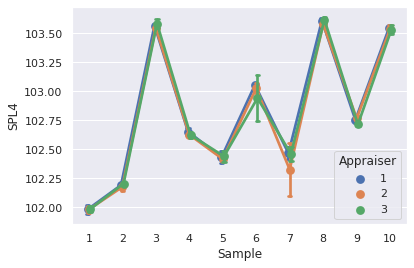

In [58]:
sns.pointplot(data=df, x='Sample', y='SPL4', hue='Appraiser', dodge=True, capsize=.1, ci='sd')

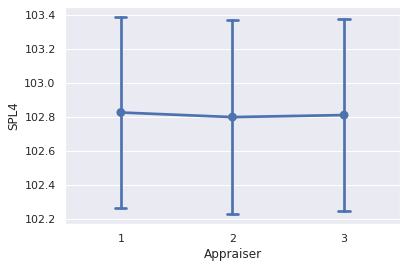

In [63]:
sns.pointplot(data=df, x='Appraiser', y='SPL4', dodge=True, capsize=.1, ci='sd'
            )

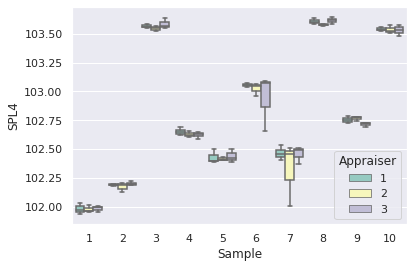

In [59]:
sns.boxplot(x="Sample", y="SPL4", hue="Appraiser", data=df, palette="Set3") 

In [60]:
# load packages
import statsmodels.api as sm
from statsmodels.formula.api import ols
# Ordinary Least Squares (OLS) model
# C(Genotype):C(years) represent interaction term
model = ols('(SPL4) ~ C(Appraiser) + C(Sample) + C(Appraiser):C(Sample)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2) #typ = 3 for unblanced
anova_table # PR (>F) is P

,sum_sq,df,F,PR(>F)
C(Appraiser),0.011008,2.0,0.928600,4.007094e-01
C(Sample),28.532622,9.0,534.870670,8.011557e-54
C(Appraiser):C(Sample),0.060493,18.0,0.566998,9.092123e-01
Residual,0.355633,60.0,NaN,NaN


In [67]:
#Two-way ANOVA with balanced design
df.anova(dv="SPL4", between=["Appraiser", "Sample"]).round(3)

,Source,SS,DF,MS,F,p-unc,np2
0,Appraiser,0.011,2,0.006,0.929,0.401,0.030
1,Sample,28.533,9,3.170,534.871,0.000,0.988
2,Appraiser * Sample,0.060,18,0.003,0.567,0.909,0.145
3,Residual,0.356,60,0.006,NaN,NaN,NaN


In [68]:
#Two-way ANOVA with unbalanced design (requires statsmodels)
df.anova(dv="SPL4", between=["Appraiser", "Sample"],effsize='n2').round(3)

,Source,SS,DF,MS,F,p-unc,n2
0,Appraiser,0.011,2,0.006,0.929,0.401,0.000
1,Sample,28.533,9,3.170,534.871,0.000,0.985
2,Appraiser * Sample,0.060,18,0.003,0.567,0.909,0.002
3,Residual,0.356,60,0.006,NaN,NaN,NaN


## Test ANOVA assumptions

In [69]:
# load packages
import scipy.stats as stats
w, pvalue = stats.shapiro(model.resid)
print(w, pvalue)

0.7692556381225586 1.424336343314181e-10


As the P-value is significant, we reject null hypothesis and conclude that data is drawn from non normal distribution.

In [70]:
pg.normality(df, group='Appraiser', dv='SPL4')

,W,pval,normal
1,0.898836,0.007867,False
2,0.889896,0.004797,False
3,0.888017,0.004331,False


In [71]:
pg.normality(df, group='Sample', dv='SPL4')

,W,pval,normal
1,0.966669,0.864836,True
2,0.828212,0.042638,False
3,0.891066,0.204620,True
4,0.973317,0.921517,True
5,0.781469,0.012522,False
6,0.604953,0.000109,False
7,0.685514,0.000961,False
8,0.905054,0.282774,True
9,0.922736,0.415377,True
10,0.948302,0.671433,True


Test variance of the samples are all equal (levene test for non normal distribution)

In [73]:
pg.homoscedasticity(df, group='Sample', dv='SPL4')

,W,pval,equal_var
levene,1.323825,0.237946,True


In [74]:
pg.homoscedasticity(df, group='Appraiser', dv='SPL4')

,W,pval,equal_var
levene,0.043634,0.957325,True


##  POST-HOC TESTING (with Tukey HSD test or more)

For equal variance

In [75]:
# load packages
from pingouin import pairwise_tukey
# perform multiple pairwise comparison (Tukey HSD)
# for unbalanced (unequal sample size) data, pairwise_tukey uses Tukey-Kramer test
m_comp = pairwise_tukey(data=df, dv='SPL4', between='Appraiser').round(3)
m_comp['Result']=m_comp['p-tukey'].apply(lambda x: 'Different'if x<0.05 else 'Not different')
m_comp

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges,Result
0,1,2,102.825,102.798,0.027,0.149,0.182,0.9,0.046,Not different
1,1,3,102.825,102.810,0.015,0.149,0.101,0.9,0.026,Not different
2,2,3,102.798,102.810,-0.012,0.149,-0.081,0.9,-0.021,Not different


In [81]:
import statsmodels.stats.multicomp as mc

comp = mc.MultiComparison(df['SPL4'], df['Appraiser'])
post_hoc_res = comp.tukeyhsd()
post_hoc_res.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
1,2,-0.027,0.9,-0.3822,0.3281,False
1,3,-0.015,0.9,-0.3702,0.3401,False
2,3,0.012,0.9,-0.3432,0.3672,False


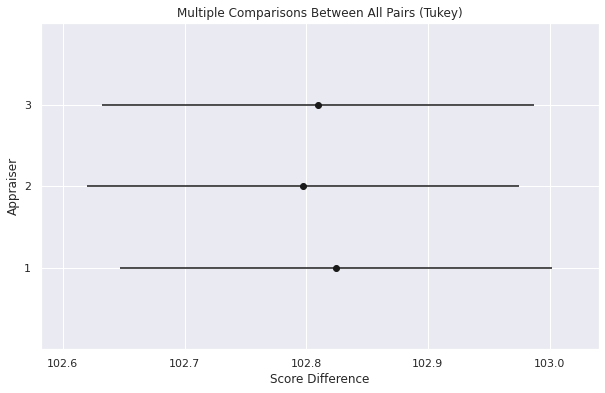

In [83]:
post_hoc_res.plot_simultaneous(ylabel= "Appraiser", xlabel= "Score Difference")
plt.show()

For unequal variance

In [80]:
m_comp=pg.pairwise_gameshowell(data=df, dv='SPL4', between='Appraiser')
m_comp['Result']=m_comp['pval'].apply(lambda x: 'Different'if x<0.05 else 'Not different')
m_comp

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges,Result
0,1,2,102.824600,102.797567,0.027033,0.149210,0.181176,57.984596,0.9,0.046172,Not different
1,1,3,102.824600,102.809567,0.015033,0.148193,0.101444,57.999563,0.9,0.025853,Not different
2,2,3,102.797567,102.809567,-0.012000,0.149412,-0.080315,57.989347,0.9,-0.020468,Not different
